# Text Processing for Accelerator project

A simplified pipeline processing text with FastText.

* Load CPA classification data and removal of unwanted text
* Basic text cleaning
* Vectorize (with FastText)
* examine the vectorization using UMAP on one hand and PCA + TSNE on the other 
* Cluster (HDBSCAN)
* Evaluate
* Visualise

In [1]:
# this bit shouldn't be necessary if we pip install -e .   in the parent directory
%load_ext autoreload
%autoreload 2

In [2]:
import functools
from pprint import pprint
from time import time
from IPython.display import display, HTML
import logging
import pandas as pd
import numpy as np
import plotly.express

In [3]:
import text_processing

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load in the CPA data

In [4]:
CPA = text_processing.fetch_files()

2021-01-28 09:43:08,316 - text_processing - INFO - cleanded CPA File imported


In [5]:
CPA[CPA.Includes.notnull()].head()

Order  Level      Code   Parent  \
3   1208795      4     01.11     01.1   
19  1208811      6  01.11.50  01.11.5   
22  1208814      6  01.11.62  01.11.6   
24  1208816      5   01.11.7    01.11   
56  1208848      6  01.13.19  01.13.1   

                                       Descr  \
3   Cereals , leguminous crops and oil seeds   
19                   Cereals straw and husks   
22                               Peas, green   
24               Dried leguminous vegetables   
56            Other leafy or stem vegetables   

                                             Includes  \
3   This class includes:  cereals, leguminous crop...   
19  This subcategory also includes:  unprepared st...   
22  This subcategory also includes:  green peas an...   
24  This category includes:   leguminous vegetable...   
56           This subcategory also includes:  parsley   

                                             Excludes  \
3                                                 NaN   
19  This subcategory excludes:  cleaned, bleached ...   
22                                                NaN   
24                                                NaN   
56                                                NaN   

         Exclusions_removed                                 Descr_old  \
3                       NaN  Cereals , leguminous crops and oil seeds   
19  whether or not chopped,                   Cereals straw and husks   
22                      NaN                               Peas, green   
24     not shelled or split               Dried leguminous vegetables   
56                      NaN            Other leafy or stem vegetables   

                                         Includes_old Category_2 Category_3  \
3   This class includes:  cereals, leguminous crop...         01       01.1   
19  This subcategory also includes:  unprepared st...         01       01.1   
22  This subcategory also includes:  green peas an...         01       01.1   
24  This category includes:   leguminous vegetable...         01       01.1   
56           This subcategory also includes:  parsley         01       01.1   

   Category_1 Category_0  
3           A          1  
19          A          1  
22          A          1  
24          A          1  
56          A          1

In [6]:
CPA1 = CPA[['Code','Descr_old','Descr','Category_0','Category_1','Category_2']].copy()
df = text_processing.clean_col(CPA1, "Descr")
df.drop('Descr',axis=1,inplace=True)

2021-01-28 09:43:08,573 - text_processing - INFO - Cleaning column: Descr 


In [7]:
df.sample(5)

Code                                          Descr_old Category_0  \
2493   27.40.4             Parts for lamps and lighting equipment          2   
3959  47.00.45  Retail trade services of plumbing and heating ...          4   
235   01.47.22           Eggs from other poultry, in shell, fresh          1   
3219  32.99.53  Instruments, apparatus and models designed for...          2   
879   13.30.12  Bleaching services of fabrics and textile arti...          2   

     Category_1 Category_2                                      Descr_cleaned  
2493          C         27                     parts lamps lighting equipment  
3959          G         47  retail trade services plumbing heating equipme...  
235           A         01                           eggs poultry shell fresh  
3219          C         32  instruments apparatus models designed demonstr...  
879           C         13  bleaching services fabrics textile articles in...

## Load FastText Pretrained

Note: This requires a fair bit of memory (peaks at about 17.5 GiB)

Recommend shutting down other kernels first, once this has loaded memory usage drops again.

This takes a few minutes to load in.

In [8]:
wv = text_processing.fetch_fasstext_pretrained(filepath="../../data/wiki.en.bin")

2021-01-28 09:43:12,491 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2021-01-28 09:47:45,497 - text_processing - INFO - Model loaded


## Vectorize descriptions using FastText

In [9]:
text_to_vec = functools.partial(text_processing.vectorize_text, wv)

df["Descr_cleaned_vectorized"] = df.Descr_cleaned.apply(
    text_to_vec
)

### Repeat earlier work on dimensionality reduction using PCA and TSNE

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = np.array(list(df["Descr_cleaned_vectorized"]))

pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

# reduce dimension with PCA
PCA_df = df.copy()
PCA_df['PCA_X'] = X_r[:,0]
PCA_df['PCA_Y'] = X_r[:,1]


# reduce dimension with TSNE
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000, verbose=0)

tsne_data = model.fit_transform(X_r)
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2"))
tsne_df2 = df.copy()
tsne_df2['dim1'] = tsne_data[:,0]
tsne_df2['dim2'] = tsne_data[:,1]
#plot_scat(tsne_df2, Cat_0_descrip,'PCA and TSNE analysis - Scikit vectorisation')


2021-01-28 09:50:53,858 - text_processing - INFO - cleanded CPA File imported
2021-01-28 09:50:54,086 - text_processing - INFO - cleanded CPA File imported


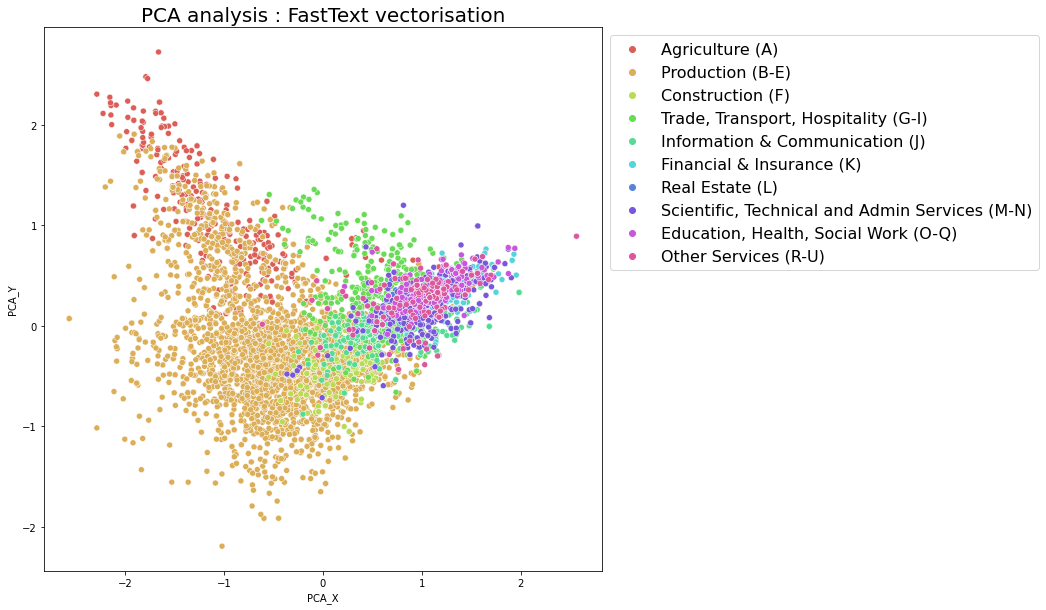

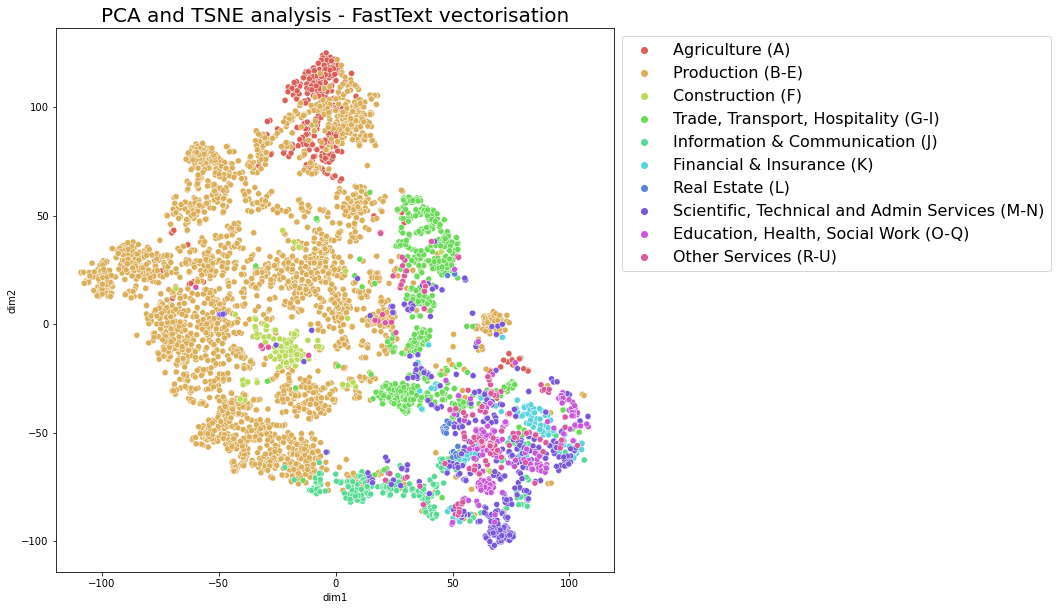

In [11]:
text_processing.plot_scat(PCA_df, '0', 'PCA analysis : FastText vectorisation')
text_processing.plot_scat(tsne_df2, '0', 'PCA and TSNE analysis - FastText vectorisation')

## Dimensionality Reduction - UMAP with 2 dimensions and TSNE to compare what was done before

2021-01-28 09:50:57,544 - text_processing - INFO - Now applying umap to reduce dimension


UMAP(min_dist=0.0, n_neighbors=10, random_state=3052528580, verbose=10)
Construct fuzzy simplicial set
Thu Jan 28 09:50:57 2021 Finding Nearest Neighbors
Thu Jan 28 09:50:57 2021 Building RP forest with 9 trees
Thu Jan 28 09:50:59 2021 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	 9  /  12
Thu Jan 28 09:51:06 2021 Finished Nearest Neighbor Search
Thu Jan 28 09:51:09 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jan 28 09:51:24 2021 Finished embedding


2021-01-28 09:53:43,772 - text_processing - INFO - cleanded CPA File imported
2021-01-28 09:53:44,059 - text_processing - INFO - cleanded CPA File imported


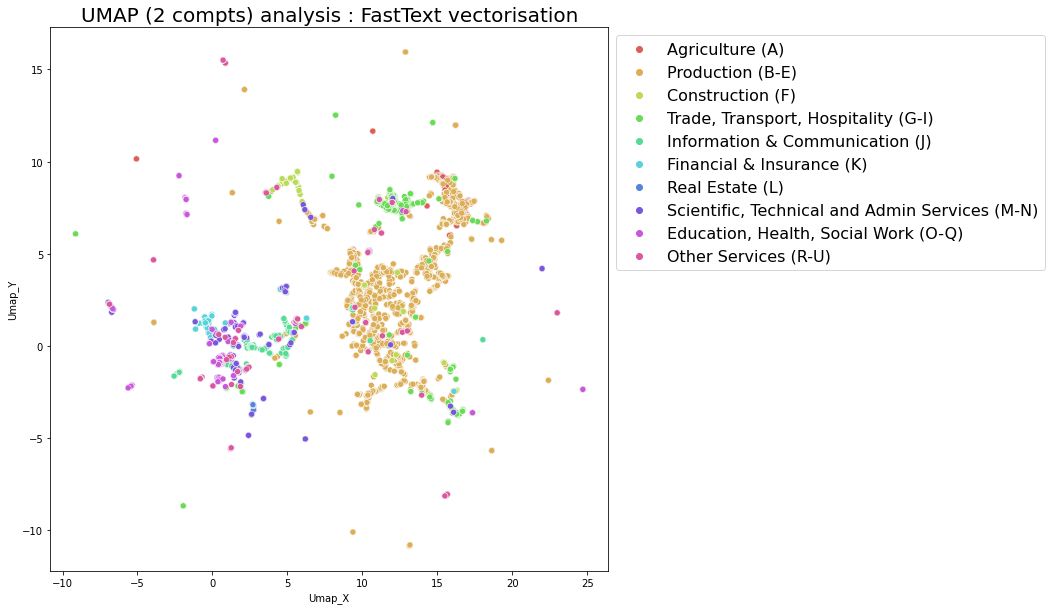

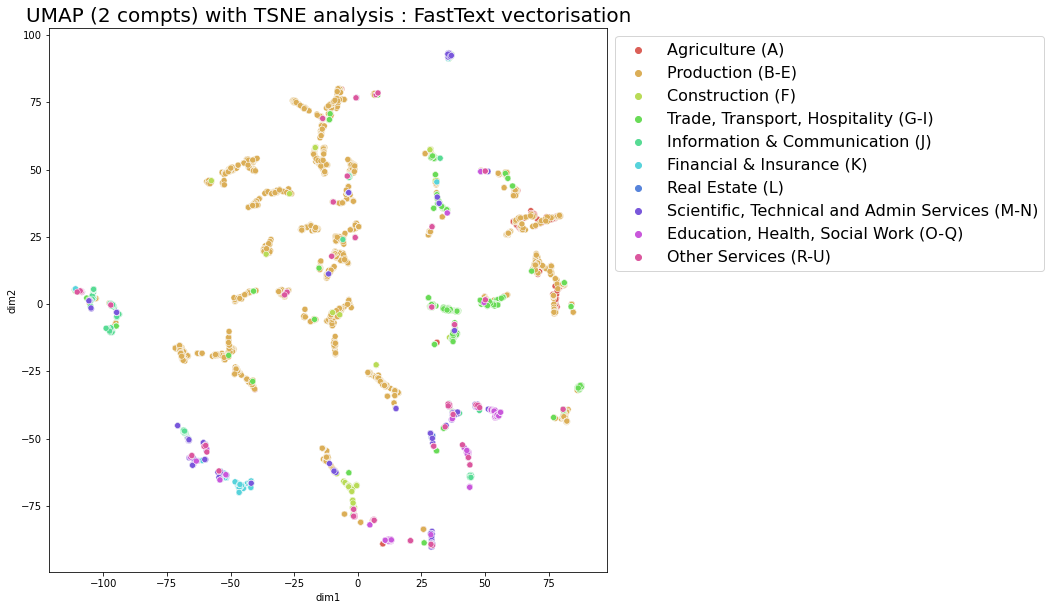

In [12]:
df["Low_dim_2"] = text_processing.reduce_dimensionality(
    df.Descr_cleaned_vectorized, 2
)

X2_r = np.array(list(df.Low_dim_2))
df3 = df.copy()
df3['Umap_X'] = X2_r[:,0]
df3['Umap_Y'] = X2_r[:,1]


tsne_data2 = model.fit_transform(X2_r)
tsne_df_new = pd.DataFrame(data=tsne_data2, columns=("dim1", "dim2"))
tsne_df3 = df.copy()
tsne_df3['dim1'] = tsne_data2[:,0]
tsne_df3['dim2'] = tsne_data2[:,1]

text_processing.plot_scat(df3, '0', 'UMAP (2 compts) analysis : FastText vectorisation')
text_processing.plot_scat(tsne_df3, '0', 'UMAP (2 compts) with TSNE analysis : FastText vectorisation')

In [14]:
#text_processing.plot_scat(df3, '1', 'UMAP (2 compts) analysis : FastText vectorisation')
#text_processing.plot_scat(tsne_df3, '1', 'UMAP (2 compts) with TSNE analysis : FastText vectorisation')

fig1 = text_processing.plotly_scat(plot_df,['Descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')
fig1.update_layout()

NameError: name 'plot_df' is not defined

## Dimensionality Reduction - UMAP with 10 dimensions 

In [13]:
# let's look again only at lowest level, level 6
df4 = df[df.Code.str.len()>7]
df4["Low_dim_10"] = text_processing.reduce_dimensionality(
    df4.Descr_cleaned_vectorized, 10
)

2021-01-28 09:53:45,330 - text_processing - INFO - Now applying umap to reduce dimension


UMAP(min_dist=0.0, n_components=10, n_neighbors=10, random_state=3052528580,
     verbose=10)
Construct fuzzy simplicial set
Thu Jan 28 09:53:51 2021 Finding Nearest Neighbors
Thu Jan 28 09:53:54 2021 Finished Nearest Neighbor Search
Thu Jan 28 09:53:55 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jan 28 09:54:07 2021 Finished embedding


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
plot_df = df5[["Category_1","Descr_cleaned", "Code", "Low_dim_10","label"]].copy()
plot_df['Category'] = plot_df['Category_1'].astype(str)
i=2
plot_df["x"] = plot_df.Low_dim_10.apply(lambda x: x[2*i])
plot_df["y"] = plot_df.Low_dim_10.apply(lambda x: x[2*i+1])

fig1 = text_processing.plotly_scat(plot_df,'1',['Descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')
fig1.update_layout()


NameError: name 'df5' is not defined

### Clustering

In [15]:
df5 = df4.copy()
df5["label"] = text_processing.cluster(df5.Low_dim_10)
df5['New_cat'] = df5.label.astype(str)

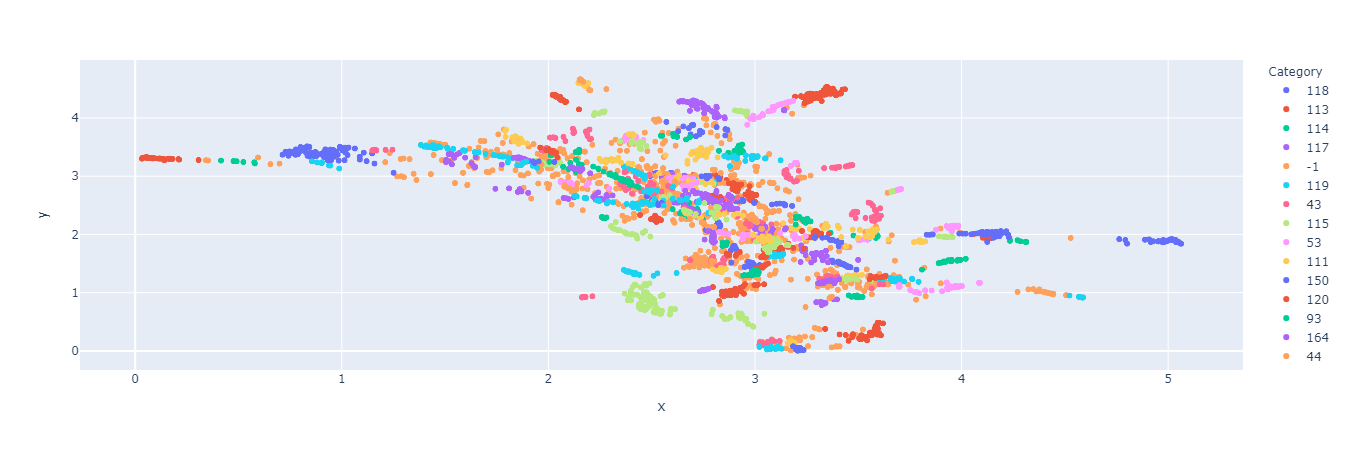

In [16]:


plot_df = df5[["Category_1","Descr_cleaned", "Code", "Low_dim_10","label"]].copy()
plot_df['Category'] = plot_df.label.astype(str)

plot_df["x"] = plot_df.Low_dim_10.apply(lambda x: x[4])
plot_df["y"] = plot_df.Low_dim_10.apply(lambda x: x[5])
# add filtering
# a function to produce a scatter plot
def scat(plot_df, true_cols):
    hover = {
        "Category":False,
        "x": False,
        "y": False
        }
    for col in true_cols:
        hover[col] = True
    fig = plotly.express.scatter(
            plot_df, 
            x="x", 
            y="y", 
            color="Category",
            hover_data=hover)
    return fig
#fig1 = text_processing.plotly_scat(plot_df,'label',['Descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')



fig1 = scat(plot_df,['Descr_cleaned','label'])
fig1.update_layout()

In [ ]:
# plot_df = df[["Category_0","Descr_cleaned", "Code", "Low_dim_10","label"]].copy()

# plot_df["x"] = plot_df.Low_dim_10.apply(lambda x: x[4])
# plot_df["y"] = plot_df.Low_dim_10.apply(lambda x: x[5])
# # add filtering
# plot_df = plot_df[plot_df.x >3]

# plot_df["Category"] = plot_df.label.astype(str)

# fig1 = scat(plot_df, ['Descr_cleaned','label'])
# fig1.update_layout(showlegend=False)

In [18]:
plot_df[plot_df.label=='3']

Category_1                                   Descr_cleaned      Code  \
1654          C     tubes pipes hoses fittings thereof plastics  22.21.29   
1761          C  ceramic pipes conduits guttering pipe fittings  23.32.13   
1934          C                        tube pipe fittings steel  24.20.40   
1995          C        aluminium tubes pipes tube pipe fittings  24.42.26   
2021          C           copper tubes pipes tube pipe fittings  24.44.26   
2032          C           nickel tubes pipes tube pipe fittings  24.45.24   
2051          C                    tube pipe fittings cast-iron  24.51.30   
2058          C            tubes pipes centrifugally cast-steel  24.52.20   
2060          C                   tube pipe fittings cast-steel  24.52.30   

                                             Low_dim_10 label Category  \
1654  [-0.41378432512283325, 0.403290718793869, 5.03...     3        3   
1761  [-0.4183225929737091, 0.40091127157211304, 5.0...     3        3   
1934  [-0.4199550151824951, 0.4008861482143402, 5.03...     3        3   
1995  [-0.4200228452682495, 0.40058523416519165, 5.0...     3        3   
2021  [-0.4186999499797821, 0.4010269045829773, 5.03...     3        3   
2032  [-0.41592270135879517, 0.4015594720840454, 5.0...     3        3   
2051  [-0.417828232049942, 0.40096020698547363, 5.03...     3        3   
2058  [-0.3838179111480713, 0.4056006669998169, 5.04...     3        3   
2060  [-0.4170982241630554, 0.4011785387992859, 5.03...     3        3   

             x         y  
1654  3.194098  3.224157  
1761  3.200697  3.225211  
1934  3.201353  3.228734  
1995  3.201797  3.230973  
2021  3.200647  3.226056  
2032  3.198107  3.223014  
2051  3.200331  3.224328  
2058  3.174272  3.177698  
2060  3.199530  3.223626

## Investigate the new categories

In [ ]:
pd.set_option('display.max_colwidth', None)

In [21]:
lab = '3'
cols = ['Code','Descr_cleaned','label','Category_2']
test_case = df5[(df5.label==lab)]
display(HTML(f'<h3>These are all the low level items with label {lab}</h3>'), test_case[cols])

cat = test_case.Category_2.values[0]
tmp = df5[df5.Category_2 == cat]
display(HTML(f'<h3>These are all the items with category {cat}</h3>'), 
tmp[cols].sort_values(by='label'))

# Now look at the clusters that intersect Category_2
labs = tmp.label.unique()
for l in labs:
    if l >=0 and l!=lab:
        display(HTML(f'<h3>These are all the itms with label {l}</h3>'))
        display(df5[df5.label==l][cols].sort_values(by='Category_2'))

Code                                   Descr_cleaned label  \
1654  22.21.29     tubes pipes hoses fittings thereof plastics     3   
1761  23.32.13  ceramic pipes conduits guttering pipe fittings     3   
1934  24.20.40                        tube pipe fittings steel     3   
1995  24.42.26        aluminium tubes pipes tube pipe fittings     3   
2021  24.44.26           copper tubes pipes tube pipe fittings     3   
2032  24.45.24           nickel tubes pipes tube pipe fittings     3   
2051  24.51.30                    tube pipe fittings cast-iron     3   
2058  24.52.20            tubes pipes centrifugally cast-steel     3   
2060  24.52.30                   tube pipe fittings cast-steel     3   

     Category_2  
1654         22  
1761         23  
1934         24  
1995         24  
2021         24  
2032         24  
2051         24  
2058         24  
2060         24

Code                                      Descr_cleaned label  \
1661  22.21.99  sub-contracted operations part manufacturing p...    -1   
1666  22.22.13       boxes cases crates similar articles plastics    -1   
1641  22.19.60  articles apparel clothing accessories vulcanis...    -1   
1667  22.22.14   carboys bottles flasks similar articles plastics    -1   
1668  22.22.19                              plastic packing goods    -1   
1676  22.23.14  doors windows frames thresholds doors shutters...    -1   
1677  22.23.15  linoleum hard non-plastic surface floor coveri...    -1   
1674  22.23.12  baths wash-basins lavatory pans covers flushin...    -1   
1678  22.23.19                         builders ware plastics nec    -1   
1651  22.21.10  monofilament  1 mm rods sticks profile shapes ...    -1   
1690  22.29.24  parts nec lamps lighting fitting illuminated n...   112   
1685  22.29.10  apparel clothing accessories including gloves ...   122   
1653  22.21.21  artificial guts hardened proteins cellulosic m...   132   
1665  22.22.12  sacks bags including cones plastics polymers e...   132   
1664  22.22.11       sacks bags including cones polymers ethylene   132   
1673  22.23.11  floor wall ceiling coverings plastics rolls fo...   135   
1689  22.29.23  tableware kitchenware household articles toile...   135   
1692  22.29.26  fittings furniture coachwork like plastics sta...   135   
1693  22.29.29                                  articles plastics   135   
1619  22.11.11    new pneumatic tyres rubber kind used motor cars    15   
1623  22.11.15  inner tubes solid cushion tyres interchangeabl...    15   
1620  22.11.12  new pneumatic tyres rubber kind used motorcycl...    15   
1621  22.11.13  new pneumatic tyres rubber kind used buses lor...    15   
1624  22.11.16          camel-back strips retreading rubber tyres    15   
1626  22.11.20                   retreaded pneumatic tyres rubber    15   
1628  22.11.99  sub-contracted operations part manufacturing r...    15   
1622  22.11.14          agrarian tyres new pneumatic tyres rubber    15   
1639  22.19.50                         rubberised textile fabrics   150   
1670  22.22.99  sub-contracted operations part manufacturing p...   158   
1691  22.29.25                    office school supplies plastics   158   
1647  22.19.99  sub-contracted operations part manufacturing r...   159   
1695  22.29.91            manufacturing services plastic products   159   
1682  22.23.99  sub-contracted operations part manufacturing b...   159   
1696  22.29.99  sub-contracted operations part manufacturing p...   159   
1637  22.19.40  conveyor transmission belts belting vulcanised...   164   
1644  22.19.72    floor coverings mats vulcanised rubber cellular   164   
1635  22.19.30    tubes pipes hoses vulcanised rubber hard rubber   164   
1633  22.19.20  unvulcanised rubber articles thereof vulcanise...   164   
1645  22.19.73  articles vulcanised rubber nec hard rubber for...   164   
1643  22.19.71  hygienic pharmaceutical articles including tea...   164   
1675  22.23.13  reservoirs tanks vats similar containers capac...    17   
1680  22.23.20                   prefabricated buildings plastics    21   
1631  22.19.10  reclaimed rubber primary forms plates sheets s...    23   
1687  22.29.21  self-adhesive plates sheets film foil tapes st...    23   
1659  22.21.42  plates sheets film foil strip plastics non-cel...    23   
1658  22.21.41    plates sheets film foil strip plastics cellular    23   
1656  22.21.30             plates sheets film foil strip plastics    23   
1688  22.29.22  self-adhesive plates sheets film foil tapes st...    23   
1654  22.21.29        tubes pipes hoses fittings thereof plastics     3   

     Category_2  
1661         22  
1666         22  
1641         22  
1667         22  
1668         22  
1676         22  
1677         22  
1674         22  
1678         22  
1651         22  
1690         22  
1685         22  
1653         22  
1665   

TypeError: '>=' not supported between instances of 'str' and 'int'

#### Cluster comparison

No, no they are not.

#### Looking at a specific case

In [22]:
wv.most_similar("gru")

[('kgb', 0.6759157776832581),
 ('smersh', 0.5931000709533691),
 ('spetsnaz', 0.5695321559906006),
 ('nkgb', 0.5644126534461975),
 ('counterintelligence', 0.5616932511329651),
 ('rezident', 0.5581782460212708),
 ('nkvd', 0.5543013215065002),
 ('nkvd/nkgb', 0.5516831278800964),
 ('gugb', 0.5502406358718872),
 ('krechetnikov', 0.5455362796783447)]

In [33]:
wv.most_similar("wheelchair", topn=30)

[('wheelchairs', 0.8490369319915771),
 ('wheelchair}}', 0.8316938281059265),
 ('wheelchairindia', 0.7333004474639893),
 ('wheelchair%', 0.7280856370925903),
 ('_wheelchairs', 0.7120068669319153),
 ('paraplegic', 0.6665257215499878),
 ('quadraplegic', 0.6246519088745117),
 ('handicapped', 0.6160231828689575),
 ('quadriplegic', 0.603029727935791),
 ('paralympian', 0.5986058712005615),
 ('paralympic', 0.5948189496994019),
 ('disabilty', 0.5897356271743774),
 ('tetraplegic', 0.5863398313522339),
 ('amputee', 0.5852821469306946),
 ('paralympians', 0.5851616859436035),
 ('wheelcase', 0.5850986242294312),
 ('paraplegics', 0.5777888298034668),
 ('paralympicsgb', 0.574120283126831),
 ('handcycling', 0.5731836557388306),
 ('crutches', 0.570719838142395),
 ('handcyclist', 0.5682808756828308),
 ('paralympics', 0.567649245262146),
 ('paraplegias', 0.561674952507019),
 ('quadriplegics', 0.5616666078567505),
 ('paraplegia', 0.5615322589874268),
 ('paralymic', 0.561187744140625),
 ('disability', 0.560

In [32]:
wv.most_similar("invalid", topn=50)

[('#invalid', 0.8136100172996521),
 ('invalidpct', 0.7742791175842285),
 ('valid/invalid', 0.7536740303039551),
 ('invalidly', 0.748623251914978),
 ('invalidy', 0.730400800704956),
 ('valid', 0.728664755821228),
 ('isgtinvalid', 0.7282124757766724),
 ('invaliding', 0.7168881893157959),
 ('invalidating', 0.7105535268783569),
 ('invalidchar', 0.7086206674575806),
 ('invalida', 0.7074924111366272),
 ('unvalid', 0.7068309187889099),
 ('invalidates', 0.7035164833068848),
 ('invalidity', 0.701622724533081),
 ('invalidi', 0.7004423141479492),
 ('invalidated', 0.6889963746070862),
 ('invalidate', 0.6782973408699036),
 ('invalidation', 0.6703834533691406),
 ('isissnvalid', 0.664084792137146),
 ('invalidations', 0.6542978286743164),
 ('isisbnvalid', 0.6539890766143799),
 ('invalidum', 0.6416858434677124),
 ('invalidtypeerror', 0.6393647193908691),
 ('invalidité', 0.6327498555183411),
 ('assertinvalidip', 0.6293273568153381),
 ('evalid', 0.6266831755638123),
 ('invalidlanguage', 0.615064442157745

In [29]:
wv.most_similar("caravan", topn=20)

[('caravans', 0.807042121887207),
 ('motorcaravan', 0.7211452722549438),
 ('caravat', 0.7202428579330444),
 ('caravanner', 0.7174221277236938),
 ('caravanning', 0.7067693471908569),
 ('caravaning', 0.7017621994018555),
 ('caravani', 0.6997472643852234),
 ('caravanners', 0.6877413988113403),
 ('caravanim', 0.6797067523002625),
 ('carava', 0.6779685020446777),
 ('caravanette', 0.6598707437515259),
 ('caravaneer', 0.6566412448883057),
 ('caravanos', 0.6545532941818237),
 ('caravan/camping', 0.6510233879089355),
 ('caravana', 0.6469882726669312),
 ('caravane', 0.6401963233947754),
 ('caravanas', 0.6352393627166748),
 ('caravaners', 0.6341027021408081),
 ('caravano', 0.6335786581039429),
 ('caravanseari', 0.6235982775688171)]